***

<br>
<div align="center" p style="font-size:50px"><b>Face Rhythm</b></div>
<br>

***

<table><tr>
<td> <img src="https://images.squarespace-cdn.com/content/5688a31305f8e23aa2893502/1614723283221-5Z5038AT7Y6KCOM2PIU4/Screenshot+from+2021-03-02+17-05-12.png?content-type=image%2Fpng" style="height: 200px"> </td>
<td> <img src="https://images.squarespace-cdn.com/content/5688a31305f8e23aa2893502/1614723856628-J89PYYSF7K7JATE2KMF9/Screenshot+from+2021-03-02+17-23-46.png?format=300w&content-type=image%2Fpng" style="height: 200px"> </td>
<td> <img src="https://images.squarespace-cdn.com/content/5688a31305f8e23aa2893502/1614723931026-OORV0RAPZNWV3R8TBOXB/Screenshot+from+2021-03-02+17-25-11.png?format=300w&content-type=image%2Fpng" style="height: 200px"> </td>
<td> <img src="https://images.squarespace-cdn.com/content/5688a31305f8e23aa2893502/1614724055033-O3GBEF1D9MULFZKI2IUJ/Screenshot+from+2021-03-02+17-27-10.png?format=300w&content-type=image%2Fpng" style="height: 200px"> </td>
<td> <img src="https://images.squarespace-cdn.com/content/5688a31305f8e23aa2893502/1614723378405-WXN74ZTT1KYZUQGDM07X/face_rhythm_banner2.png?format=1000w&content-type=image%2Fpng" style="height: 200px"> </td>
</tr></table>

***

##### Notebook Shortcuts
- **[Notebook Setup](#Notebook-Setup)**: Prepare all the necessary config files and folders
- **[Set ROI](#Set-ROI)**: Set the ROI for the analysis
- **[Run Optic Flow](#Run-Optic-Flow)**: Run the optic flow analysis
- **[Clean Optic Flow](#Clean-Optic-Flow)**: Optic flow post-processing
- **[Convolutional Dimensionality Reduction](#Convolutional-Dimensionality-Reduction)**: Convolutional Dimensionality Reduction
- **[Analysis](#Analysis)**: Decompose and Analyze the optic flow data in many ways

***

# Tips on running this notebook:
In theory it would be nice if you could just enter the path of the video(s) and just let it run all the way through. In practice, there are a few hoops to jump through
- Run the Notebook Setup Block (two blocks below this one). This should pretty much always be done, even if you are loading precomputed file from disk instead of calculating them. This step loads in some useful meta data used throughout.
- Even if you are restarting at a specific point in your analysis, run your Setup Block then head down to your current analysis step cell 
- There are two options for calculating the optic flow (parameters set independently as well), one single-threaded and one multi-threaded. Do parameter tuning on the single-threaded one so you can quit out of it, as well as watch the calculation as it happens with showVideo_pref=1. The multi-threaded one is only faster if you have a lot of cores in your CPU (>10), then it's faster, else stick with the single-threaded version and set showVideo_pref=0.

### The most important parameters:  
***(Consider all of these before you run the code for the first time)***
- Optic flow params:
    - **'spacing'**: ~ 3 to 12. Spacing between dots, in pixels. Inversely related to number of dots to use in the calculation. Try to keep the number of dots below 2000 if possible (eats up memory and computation time). More dots generally means better final results, more robust to outliers and weird stuff. I'd make the spacing as small (more dots) as you can go before you run out of RAM in the final calculations
    - **lk_params 'win_size'**: ~ 25,25 to 80,80. This is the spatial integration window for the optical flow measurement. Try to make it as small as possible without it becoming unstable. The two values are for X and Y length of square integration window. Probably keep the same for most applications
- Outlier removal params:
    - **outlier_threshold_positions**: ~ 20 to 100. If a dot strays more than this many pixels away from its anchor position, its displacement in the dimension it cross the threshold in, for those time points (and some time points around it, see params below), for that dot only, will be set to zero
    - **outlier_threshold_displacements** ~ 5 to 25. Similar to above, but for displacement. Only the outlier time points are removed (no window around outliers considered).
    - **framesHalted_beforeOutlier**: ~ 0 to 30. The number of frames to also remove before detected outlier events. Consider what is causing your outlier event. If it is an arm movement or something, how long does such a movement last? How long before it will cause a dot to move to the outlier threshold?
    - **framesHalted_afterOutlier**: ~ 0 to 10. Simlar to above but for after an outlier event is detected
    - **relaxation_factor** : ~ 0.03 to 0.1. This is the rate of the exponential decay / relaxation / attraction back to the anchor position that a point undergoes. It is meant to prevent baseline drift. Think of it like a high pass on the dot position trace
- Spectral analysis params:
    - **win_len**: ~ 0.1 to 1.0. The length of the time window used for the short-time Fourier transform. Longer gives better spectral resolution, shorter gives better temporal resolution. There are several other parameters that are related but this is the most important. Longer windows (along with decreasing the overlap parameter) also decrease the size of the output spectrograms, which can help with memory and computation time in the subsequent analyses
- TCA:
    - **rank = 6**: ~ 2 to 10. The number of factors to look for in the PARAFAC model. More can be good but less reproduceable, but less can mix together obviously different factors

***
<center><h1>Notebook Setup</h1></center>

***

### Creates config and locates videos

**Crucially, always run this first cell every time you run this notebook.**

Also, generally make sure to read through the config parameters before running.

The Project path is the path to a folder (existing or not) where we will store our derived files. I recommend creating a project folder and then copying this notebook into that folder.
The Video path is the path to the folder with all the raw videos. 
The session name will determine the name of the config. You might create multiple configs if you want to re-run the same data with slightly different parameters

In [1]:
# ALWAYS RUN THIS CELL
# widen jupyter notebook window
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:95% !important; }</style>"))

# Import libraries
import cv2

import matplotlib.pyplot as plt
import numpy as np
import torch.cuda

from face_rhythm.util import helpers
from pathlib import Path

# SET THE PROJECT PATH, DATA PATH, and (optionally) session name
project_path     = Path('/media/rich/bigSSD RH/res2p/Camera data/round 4 experiments/mouse 11.5/20210121/cam1/FR_run2/').resolve()
video_path       = Path('/media/rich/bigSSD RH/res2p/Camera data/round 4 experiments/mouse 11.5/20210121/cam1/').resolve()
session_name     = 'test'
overwrite_config = False
remote           = False # cv2 doesn't play nicely with ssh/slurm connections, set true if using that

config_filepath = helpers.setup_project(project_path, video_path, session_name, overwrite_config, remote)

OpenCV version: 4.4.0
Pytorch version: 1.7.0


In [2]:
# IMPORT VIDEOS

config = helpers.load_config(config_filepath)

# We handle this tag cleverly
# If you specify a unique filename, then we'll just load one video
# If you specify a filename prefix, then we'll load all videos that fit that prefix
config['fileName_vid_prefix'] = 'fc2_save_2021-01-21-202339-' 
config['print_fileNames_pref'] = 1

helpers.save_config(config, config_filepath)

helpers.import_videos(config_filepath)
helpers.get_video_data(config_filepath)
helpers.create_nwb(config_filepath)

number of videos: 73
number of frames in FIRST video (roughly):  6020
number of frames in ALL videos (roughly):   436359
Sampling rate pulled from video file metadata:   120.005 frames per second

 ['/media/rich/bigSSD RH/res2p/Camera data/round 4 experiments/mouse 11.5/20210121/cam1/fc2_save_2021-01-21-202339-0000.avi'
 '/media/rich/bigSSD RH/res2p/Camera data/round 4 experiments/mouse 11.5/20210121/cam1/fc2_save_2021-01-21-202339-0001.avi'
 '/media/rich/bigSSD RH/res2p/Camera data/round 4 experiments/mouse 11.5/20210121/cam1/fc2_save_2021-01-21-202339-0002.avi'
 '/media/rich/bigSSD RH/res2p/Camera data/round 4 experiments/mouse 11.5/20210121/cam1/fc2_save_2021-01-21-202339-0003.avi'
 '/media/rich/bigSSD RH/res2p/Camera data/round 4 experiments/mouse 11.5/20210121/cam1/fc2_save_2021-01-21-202339-0004.avi'
 '/media/rich/bigSSD RH/res2p/Camera data/round 4 experiments/mouse 11.5/20210121/cam1/fc2_save_2021-01-21-202339-0005.avi'
 '/media/rich/bigSSD RH/res2p/Camera data/round 4 experime

***
<center><h1>Set ROI</h1></center>

***

### Manually specify your roi

This is good if your animal doesn't fill the view and if you have stationary objects nearby.

In [3]:
%matplotlib notebook

from face_rhythm.util import helpers
from face_rhythm.util import set_roi

### Select POLYGON SUBFRAME for DISPLACEMENT Eignfaces
## This block of code will pop up a little GUI. Click around the
## region of the face that you want to include in the analysis.
## When you are done, click the 'Disconnect mpl' button


config = helpers.load_config(config_filepath)
config['vidToSet'] = 1 # 1 indexed. Sets the video to use to make an image
config['frameToSet'] = 2 # 1 indexed. Sets the frame number to use to make an image
config['load_from_file'] = False
helpers.save_config(config, config_filepath)

if config['load_from_file']:
    set_roi.get_roi(config_filepath)    
else:
    frame, bbox_selector = set_roi.get_roi(config_filepath)

In [4]:
# Don't run this until you're done selecting
if not config['load_from_file']:
    set_roi.process_roi(config_filepath, frame, bbox_selector)

***
<center><h1>Run Optic Flow</h1></center>

***

### Run as either single- or multi-threaded depending on run time and number of dots

Multithread is generally 2X to many-X faster, but may fail when too many dots are selected (memory overload)

*If show video set to true on a remote connection, the video won't show, but it will save to the proj folder.*

In [6]:
from face_rhythm.optic_flow import optic_flow

## Important assumptions about using this code verses the single (ish) threaded version:
## 1. numFrames (per file) + 1000 (USING OPENCVs cv2.CAP_PROP_FRAME_COUNT) must be > true number of frames
##  as found using the imageio import method
## 2. Debugging is hard. If you interrupt the kernel while it's doing the parallel pool, the kernel goofs
##  and generally requires a restart

### == PREFERENCES ==

config = helpers.load_config(config_filepath)

config['vidNums_toUse'] = list(range(config['numVids'])) ## 0 indexing. Must be a list
# config['vidNums_toUse'] = [10] # comment this in to look at specific videos by their index
config['spacing'] = 3  ## This is the distance between points in the grid (both in x and y dims)

config['showVideo_pref'] = False  ## much faster when video is off. If 'remote' option chosen (from first cell block), video will be saved as file in project folder.
config['test_len'] = 10 # used only for remote users when showVideo_pref==True
config['dot_size'] = 1  ## for viewing purposes

## below will print the fps ever 'fps_counterPeriod' . Useful for checking the approximate speed of import.
## Best to turn off when doing a full run. (this is mostly for optimizing and debugging)
config['printFPS_pref'] = False
config['fps_counterPeriod'] = 10 ## number of frames to do a tic toc over

## Parameters for lucas kanade optical flow
## win size: spatial integration window (make small as possible, but make bigger if youre having issues with outliers)
## max level: only moderate effects if everything working properly. Keep around 3.
## criteria values have to do with the search algorithm. For speed: EPS small, COUNT big.
config['lk_winSize']  = (10,10)
config['lk_maxLevel'] = 4
config['lk_criteria']    = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 3, 0.001)

config['optic_recursive'] = True
config['optic_recursive_relaxation_factor'] = 0.01
config['optic_multithread'] = False # MUST be false if remote==False and showVideo_pref==True

if config['optic_recursive']==True and config['optic_multithread']==True:
    raise NameError("Incompatible option combination:  If optic_recursive==True, optic_multithread MUST ==False \n\
The recursive calculation is done serially, so it is not possible to parallelize it.")
    
helpers.save_config(config, config_filepath)


### == CALCULATION ==

optic_flow.optic_workflow(config_filepath)

== Beginning optic flow computation ==
number of points: 2387
Optic Flow Set Up. Elapsed time: 10.84 seconds

 Calculating displacement field: video # 1/73
time elapsed: 26 seconds. Capture rate: 226.777 fps

 Calculating displacement field: video # 2/73
time elapsed: 52 seconds. Capture rate: 228.444 fps

 Calculating displacement field: video # 3/73
time elapsed: 1.313 minutes. Capture rate: 229.279 fps

 Calculating displacement field: video # 4/73
time elapsed: 1.75 minutes. Capture rate: 229.173 fps

 Calculating displacement field: video # 5/73
time elapsed: 2.189 minutes. Capture rate: 229.051 fps

 Calculating displacement field: video # 6/73
time elapsed: 2.63 minutes. Capture rate: 228.872 fps

 Calculating displacement field: video # 7/73
time elapsed: 3.067 minutes. Capture rate: 228.961 fps

 Calculating displacement field: video # 8/73
time elapsed: 3.501 minutes. Capture rate: 229.281 fps

 Calculating displacement field: video # 9/73
time elapsed: 3.939 minutes. Capture

***
<center><h1>Clean Optic Flow</h1></center>

***

### Clean up displacements traces and make good positions traces

Check the parameters here, they are essential for getting good results

== Beginning outlier removal ==
Flagrant Outliers Removed. Elapsed time: 9.96 seconds
Made integrated position traces. Elapsed time: 7.57 seconds
Made extended outliers trace. Elapsed time: 2.15 minutes
All outliers removed. Elapsed time: 40.58 seconds
Made a new integrated position trace. Elapsed time: 78.6 seconds
Final absolute position trace. Elapsed time: 42.24 seconds


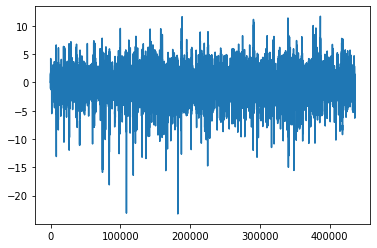

Saving positions in Group Optic Flow
Saving positions_absolute in Group Optic Flow
total elapsed time. Elapsed time: 10.05 minutes
== End outlier removal ==


In [7]:
%matplotlib inline

from face_rhythm.optic_flow import clean_results

## Create position trace from displacements
## This block does a few things:

## 1. Finds outliers: These are currently defined as time points when the integrated position goes beyond some threshold.
##  Note that since displacements are calculated for x and y separately, outlier events are also separated into x outlier events
##  and y outlier events.

## 2. Sets displacements during outlier events to ZERO: There are some parameters below that define the time window (in frames)
##  before and after outliers to also set to zero. Note again, that DISPLACEMENT (the derivative of position) is set to zero, 
##  effectively pausing the position of the ingegrated position.

## 3. Rectifies the position to its 'anchor position': I am defining position as the integrated displacement arising from a STATIC
##  place in the image. Because this analysis is image agnostic, drift naturally occurs. This term counteracts drift by simply
##  relaxing each dot's position back to the center of its displacement analysis window. This term should be as low as possible
##  because it also acts as a high pass filter, thus precluding analysis of slow timescale changes.

## Note that using a standard frequency filter (fir, iir) here for the rectification / relaxation doesn't work well

config = helpers.load_config(config_filepath)
config['outlier_threshold_positions'] = 25 ## in pixels. If position goes past this, short time window before and including outlier timepoint has displacement set to 0 
config['outlier_threshold_displacements'] = 5 ## in pixels. If displacement goes past this, displacement set to 0 at those time points
config['framesHalted_beforeOutlier'] = 20 # in frames. best to make even
config['framesHalted_afterOutlier'] = 4 # in frames. best to make even
config['relaxation_factor'] = 0.001 # This is the speed at which the integrated position exponentially relaxes back to its anchored position. Make ~0.005 to 0.05 for face video at 120 Hz
config['pixelNum_toPlot'] = 10
helpers.save_config(config, config_filepath)

clean_results.clean_workflow(config_filepath)

***
<center><h1>Convolutional Dimensionality Reduction</h1></center>

***

### Do some denoising and to get the number of dots down to a managable number

In particular, it is nice for the batched CP decomposition later that the batches can be as big as possible in the temporal dimension, so doing some mild convolutional dim reduction first is helpful.

== Beginning convolutional dimensionality reduction ==



Kernel created. Elapsed time: 33.0 seconds
number of points: 1337
Points spaced out. Elapsed time: 0.03 seconds


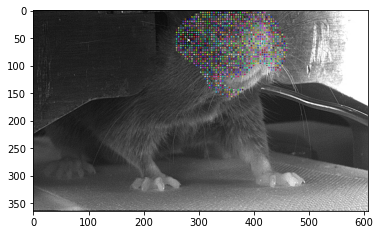

100%|██████████| 1337/1337 [27:29<00:00,  1.23s/it]


Influence computed. Elapsed time: 27.56 minutes
Saving positions_convDR_meanSub in Group Optic Flow
Saving positions_convDR_absolute in Group Optic Flow
total elapsed time. Elapsed time: 30.52 minutes
== End convolutional dimensionality reduction ==


In [4]:
%matplotlib inline
# %load_ext autoreload
# %autoreload 2

from face_rhythm.optic_flow import conv_dim_reduce

config = helpers.load_config(config_filepath)

pointInds_toUse = helpers.load_data(config_filepath, 'path_pointInds_toUse')

# Create kernel
config['cdr_width_cosKernel'] = 6 # This is the radius of a 2-dimensional cosine kernel. If you get an error about SVD not working, probably increase this
config['cdr_num_dots'] = pointInds_toUse.shape[0]

# Distance between points in the grid
config['cdr_spacing'] = 4

# For displaying dots
config['cdr_vidNum'] = 0 # 0 indexed
config['cdr_frameNum'] = 0 # 0 indexed
config['cdr_dot_size'] = 1

# Coefficients of influence 
config['cdr_num_components'] = 3
helpers.save_config(config, config_filepath)

conv_dim_reduce.conv_dim_reduce_workflow(config_filepath)

### Display or Save video of dots

In [3]:
# conv_dim_reduceim_reduce.display_displacements(config_filepath , )

***
<center><h1>Analysis</h1></center>

***

### Decompose and Analyze the Data in different ways

Below you'll find the following:
- PCA done on raw positions
- Spectral analysis of every pixels to transoform the basis to be oscillatory
- TCA done on the spectra
- A lonely t-SNE plot of the temporal factors

### PCA
The X and Y displacements are concatenated and run together. Something interesting to try would be to transform to polar coordinates, concatenate and run that way. Maybe TCA on the positions with magnitude vs angle being one of the dimensions would make sense.

== Beginning pca ==
PCA complete. Elapsed time: 18.55 seconds


<IPython.core.display.Javascript object>


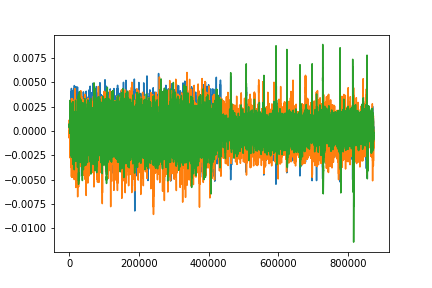

<IPython.core.display.Javascript object>


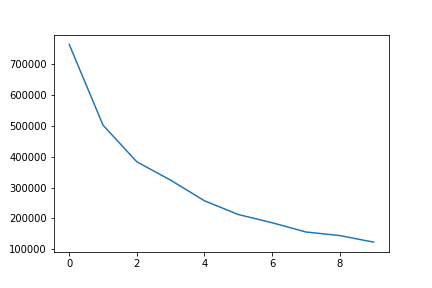

<IPython.core.display.Javascript object>


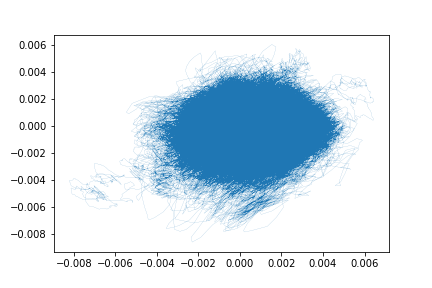

<IPython.core.display.Javascript object>


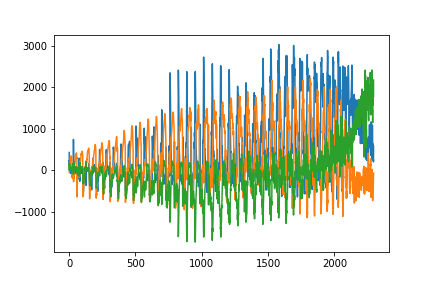

Saving scores_points in Group PCA
total elapsed time. Elapsed time: 106.63 seconds
== End pca ==


In [8]:
from face_rhythm.analysis import pca

%matplotlib notebook
%matplotlib notebook
pca.pca_workflow(config_filepath, 'positions_absolute')

### Positional TCA

In [4]:
from face_rhythm.analysis import tca

%matplotlib inline

### Prepare Tensorly
# If the input is small ( < half the size of your GPU memory) and you have CUDA, set to 'gpu'. It's super fast.

config = helpers.load_config(config_filepath)
config['tca_pref_useGPU'] = False

if config['tca_pref_useGPU']:
    cuda_device_number = torch.cuda.current_device()
    print(f"using CUDA device: 'cuda:{cuda_device_number}'")
    device = f'cuda:{cuda_device_number}'
else:
    print(f"using CPU")
    device = 'cpu'  

config['tca_device'] = device
config['tca_rank'] = 4
config['tca_init'] = 'random'
config['tca_vid_display'] = False
config['tca_vid_save'] = True
positional_path = project_path / 'viz' / 'positional'
positional_path.mkdir(parents=True, exist_ok=True)
config['tca_vid_dir'] = str(positional_path)
config['tca_verbosity'] = 0
config['tca_n_iters'] = 100
config['tca_display_frames'] = 100
helpers.save_config(config, config_filepath)

tca.positional_tca_workflow(config_filepath, 'positions','positions_absolute') # you can use differe positions data

using CPU
== Beginning Positional TCA Workflow ==


OSError: Unable to create file (unable to open file: name = '/media/rich/bigSSD RH/res2p/Camera data/round 4 experiments/mouse 11.5/20210121/cam1/FR_run2/data/fc2_save_2021-01-21-202339-.nwb', errno = 17, error message = 'File exists', flags = 15, o_flags = c2)

### Spectral Analysis
I've played with a few different methods. While multiresolution methods seems ideal for this use-case, It just ends up severly overrepresenting low frequency factors, making noisier high frequency factors, and doing an overall worse job at reconstruction.
A good ol' multitaper short time fourier transform seems to work fine. Adding in raw positions to subsequent dimensionality reduction later on seems like a natural thing to do, as single resolution spectral analysis ends up kind of ignoring slower dynamics.

bins_per_octave: 7 bins/octave
minimum frequency (fmin): 1.393 Hz
maximum frequency (fmax): 60.00238983 Hz
Nyquist                 : 60.00240009600384 Hz
number of frequencies:    38 bins
Frequencies: [ 1.538  1.698  1.875  2.07   2.286  2.524  2.786  3.076  3.397  3.75
  4.141  4.571  5.047  5.573  6.153  6.793  7.5    8.281  9.143 10.095
 11.145 12.306 13.586 15.001 16.562 18.286 20.189 22.291 24.611 27.173
 30.001 33.124 36.572 40.379 44.582 49.222 54.346 60.002]


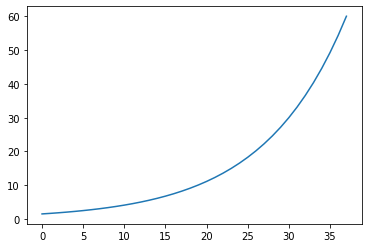

In [5]:
### Prepare Tensorly
# If the input is small ( < half the size of your GPU memory) and you have CUDA, set to 'gpu'. It's super fast.

config = helpers.load_config(config_filepath)

eps = 1.19209e-07 # float32 epsilon

hop_length = 16
fmin_rough = 1.6
Fs = config['vid_Fs']
sr = Fs
n_bins = 38
bins_per_octave = int(np.round((n_bins) / np.log2( (Fs/2)/fmin_rough )))
fmin = ( (Fs/2)/(2**((n_bins)/bins_per_octave)) ) - (2*eps)
fmax = fmin*(2**((n_bins)/bins_per_octave))

freqs_Sxx = fmin*(2**((np.arange(n_bins)+1)/bins_per_octave))

print(f'bins_per_octave: {round(bins_per_octave)} bins/octave')
print(f'minimum frequency (fmin): {round(fmin,3)} Hz')
print(f'maximum frequency (fmax): {round(fmax,8)} Hz')
print(f'Nyquist                 : {sr/2} Hz')
print(f'number of frequencies:    {n_bins} bins')
plt.figure()
plt.plot(freqs_Sxx)
print(f'Frequencies: {np.round(freqs_Sxx , 3)}')

== Beginning Spectrogram Computation ==
Preallocation completed. Elapsed time: 24.11 seconds
starting spectrogram calculation



completed spectrogram calculation
Info about Sxx_allPixels:

Shape: (1337, 38, 27273, 2)
Number of elements: 2771264076
Data type: float32
size of Sxx_allPixels: 11.085 GB
Spectrograms computed. Elapsed time: 17.58 minutes
Saving Sxx_allPixels in Group CQT
Saving Sxx_allPixels_norm in Group CQT
Saving Sxx_allPixels_normFactor in Group CQT
total elapsed time. Elapsed time: 19.53 minutes
== End spectrogram computation ==


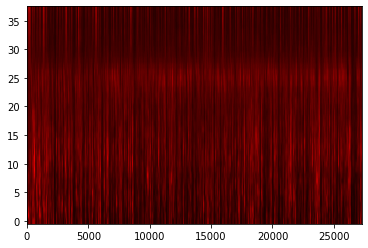

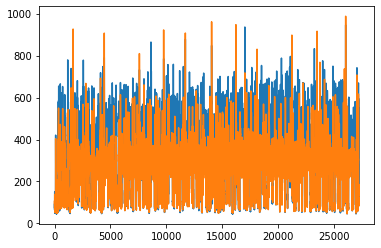

In [6]:
from face_rhythm.analysis import spectral_analysis

### Parameters for multitaper short-time Fourier transform

config = helpers.load_config(config_filepath)
config['cqt_hop_length'] = hop_length
config['cqt_sr'] = sr
config['cqt_n_bins'] = n_bins
config['cqt_bins_per_octave'] = bins_per_octave
config['cqt_fmin'] = fmin
config['cqt_fmin_rough'] = fmin_rough
config['cqt_fmax'] = fmax
helpers.save_config(config, config_filepath)

helpers.save_data(config_filepath, 'freqs_Sxx', freqs_Sxx)

# CQT spectrogram for every pixel
# this code was previously parallelized, 
# but it's pretty quick compared to the other steps, 
# so might as well keep it simple

spectral_analysis.cqt_all(config_filepath, 'positions_convDR_meanSub')

In [11]:
# from face_rhythm.analysis import spectral_analysis

# # Positional CQT

# config = helpers.load_config(config_filepath)
# config['cqt_hop_length'] = 8
# helpers.save_config(config, config_filepath)

# spectral_analysis.cqt_positions(config_filepath)

### TCA
There are two major tensor packages, one is tensortools (made by an acquaintance named Alex Williams) and the other is Tensorly.
Tensorly seems to be more packaged up and has some options to use some advanced backends like torch, tf, and mxnet. Though there are
a couple of nice features in tensortools that Tensorly doesn't have, though. Generally tensortools gives better reconstructions, but takes
much longer to do it.

This function also spits out a ton of plots, consult Rich or Akshay for interpretation.

In [2]:
from face_rhythm.analysis import tca

# %matplotlib inline

config = helpers.load_config(config_filepath)

### Prepare Tensorly

# If the input is small ( < half the size of your GPU memory) and you have CUDA, set to 'gpu'. It's super fast.

config['tca_pref_useGPU'] = True

if config['tca_pref_useGPU']:
    cuda_device_number = torch.cuda.current_device()
    print(f"using CUDA device: 'cuda:{cuda_device_number}'")
    device = f'cuda:{cuda_device_number}'
else:
    print(f"using CPU")
    device = 'cpu'  

config['tca_device'] = device
config['tca_rank'] = 8
config['tca_init'] = 'random'
config['tca_tolerance'] = 1e-06
config['tca_vid_display'] = False
config['tca_vid_save'] = False
path_frequential = project_path / 'viz' / 'frequential'
path_frequential.mkdir(parents=True, exist_ok=True)
config['tca_vid_dir'] = str(path_frequential)
config['tca_verbosity'] = 1
config['tca_n_iters'] = 1000
config['tca_display_frames'] = 500
helpers.save_config(config, config_filepath)

tca.full_tca_workflow(config_filepath)

using CUDA device: 'cuda:0'
== Beginning Full TCA Workflow ==
Size of input (spectrogram): torch.Size([1337, 38, 27273, 2])
reconstruction error=0.6819030046463013
iteration 1, reconstraction error: 0.6699667572975159, decrease = 0.0119362473487854
iteration 2, reconstraction error: 0.6617776155471802, decrease = 0.008189141750335693
iteration 3, reconstraction error: 0.6544958353042603, decrease = 0.007281780242919922
iteration 4, reconstraction error: 0.6473231911659241, decrease = 0.007172644138336182
iteration 5, reconstraction error: 0.6398518681526184, decrease = 0.007471323013305664
iteration 6, reconstraction error: 0.6319240927696228, decrease = 0.007927775382995605
iteration 7, reconstraction error: 0.6237553954124451, decrease = 0.008168697357177734
iteration 8, reconstraction error: 0.6154183149337769, decrease = 0.008337080478668213
iteration 9, reconstraction error: 0.6076087951660156, decrease = 0.0078095197677612305
iteration 10, reconstraction error: 0.6005474925041199

# Play with the outputs!

Everything below is to demonstrate how to load, manipulate, and play with the outputs of the above analysis

In [14]:
# Load the config file. This holds all the parameters and the filepaths.
config = helpers.load_config(config_filepath)
# values can be accessed using python's dict formatting. For example:
print(config['vid_height'])

364


## Outputs:
Below is the output tree structure of the NWB file

In [15]:
helpers.dump_nwb(config_filepath)

CQT
     Sxx_allPixels:    (2, 1337, 38, 27273)   ,  float32
     Sxx_allPixels_norm:    (2, 1337, 38, 27273)   ,  float32
     Sxx_allPixels_normFactor:    (2, 27273)   ,  float32
Optic Flow
     displacements:    (436359, 2387, 2)   ,  float64
     positions:    (436359, 2387, 2)   ,  float64
     positions_absolute:    (436359, 2387, 2)   ,  float64
     positions_convDR_absolute:    (436359, 1337, 2)   ,  float64
     positions_convDR_meanSub:    (436359, 1337, 2)   ,  float64
     positions_recursive:    (436359, 2387, 2)   ,  float64
TCA
     factors_frequential_dim0:    (8, 1337)   ,  float32
     factors_frequential_dim1:    (8, 38)   ,  float32
     factors_frequential_dim2:    (8, 27273)   ,  float32
     factors_frequential_dim3:    (8, 2)   ,  float32
     factors_frequential_temporal_interp:    (8, 436358)   ,  float64


## Example of how to access NWB output data

<IPython.core.display.Javascript object>


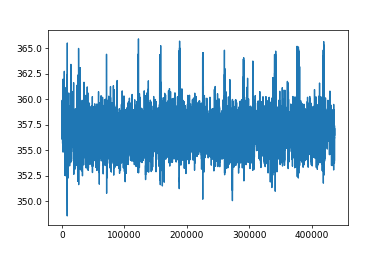

In [5]:
import pynwb
import matplotlib.pyplot as plt
import numpy as np

config = helpers.load_config(config_filepath)
nwb_path = config['path_nwb']
io = pynwb.NWBHDF5IO(nwb_path, 'r')
nwbfile = io.read() # make sure to io.close() after you are done with the nwbfile

example_data = nwbfile.processing['Face Rhythm']['Optic Flow']['positions_absolute'].data

%matplotlib notebook
plt.figure()
plt.plot(example_data[:,100,0])

In [6]:
io.close()

# Look at the output of the TCA

In [46]:
# For plotting purposes, it is nice to have the appropriate x-axis to the spectral component. This is saved as a .npy file

dir_faceRhythm = r'/media/rich/bigSSD RH/res2p/Camera data/round 4 experiments/mouse 11.5/20210121/cam1/FR_run2/data'

fileName_freqs_Sxx = 'freqs_Sxx.npy'
# fileName_faceRhythm = 'positions_new_sansOutliers.npy'
freqs_Sxx = np.load(f'{dir_faceRhythm}/{fileName_freqs_Sxx}')

<IPython.core.display.Javascript object>


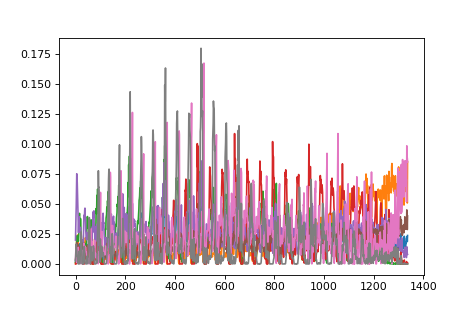

<IPython.core.display.Javascript object>


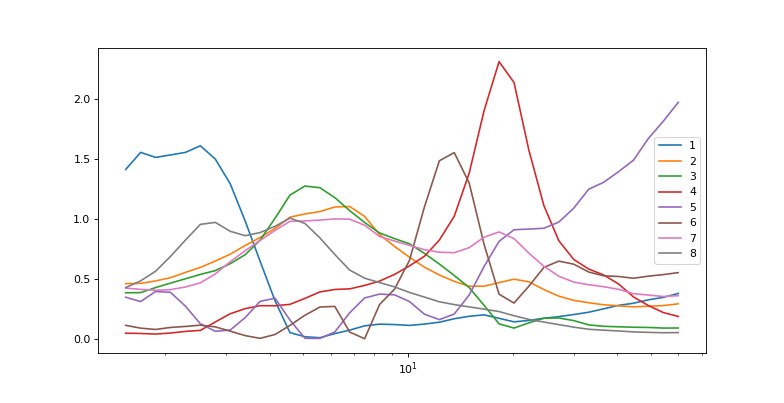

<IPython.core.display.Javascript object>


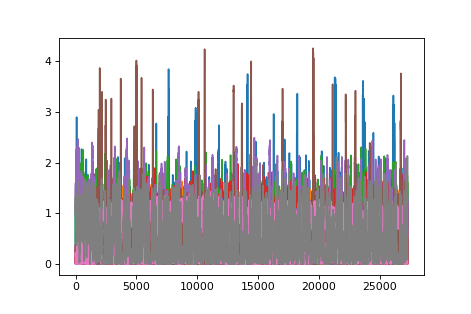

<IPython.core.display.Javascript object>


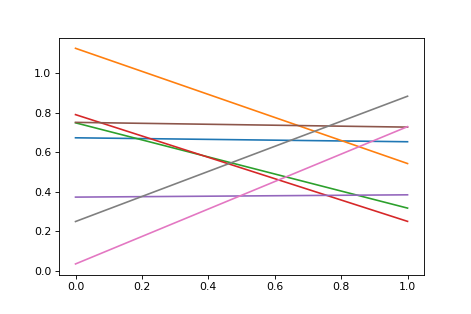

In [51]:
%matplotlib notebook
%matplotlib notebook
plt.figure()
plt.plot(np.array(nwbfile.processing['Face Rhythm']['TCA']['factors_frequential_dim0'].data).T);
plt.figure()
plt.plot(freqs_Sxx , np.array(nwbfile.processing['Face Rhythm']['TCA']['factors_frequential_dim1'].data).T);
plt.legend(['1','2','3','4','5','6','7','8'])
plt.xscale('log')
plt.figure()
plt.plot(np.array(nwbfile.processing['Face Rhythm']['TCA']['factors_frequential_dim2'].data).T);
plt.figure()
plt.plot(np.array(nwbfile.processing['Face Rhythm']['TCA']['factors_frequential_dim3'].data).T);

<IPython.core.display.Javascript object>


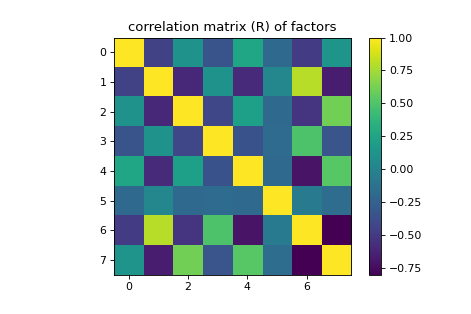

<IPython.core.display.Javascript object>


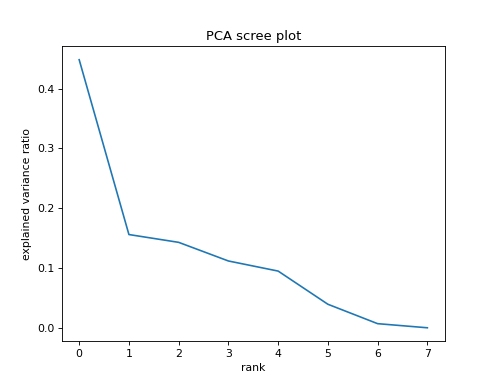

Text(0.5, 1.0, 'PCA scree plot')

In [40]:
# Let's check out the rank of the output temporal components

import sklearn as sk
plt.figure()
plt.imshow(np.corrcoef(np.array(nwbfile.processing['Face Rhythm']['TCA']['factors_frequential_dim2'].data)))
plt.colorbar()
plt.title('correlation matrix (R) of factors')

pca = sk.decomposition.PCA(n_components=8)
pca.fit(np.array(nwbfile.processing['Face Rhythm']['TCA']['factors_frequential_dim2'].data))
output_PCA = pca.components_.transpose()
plt.figure()
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('rank')
plt.ylabel('explained variance ratio')
plt.title('PCA scree plot')

## Example of how to playback movie

In [8]:
from face_rhythm.analysis import tca

tca.more_factors_videos(config_filepath , np.array(nwbfile.processing['Face Rhythm']['TCA']['factors_frequential_dim0'].data).T , 
                        np.array(nwbfile.processing['Face Rhythm']['Optic Flow']['positions_convDR_absolute'].data).transpose((1,2,0)),
                       600,1)
# tca.more_factors_videos(config_filepath , np.random.rand(1337,8) , 
#                         np.array(nwbfile.processing['Face Rhythm']['Optic Flow']['positions_convDR_absolute'].data).transpose((1,2,0)),
#                        600, 1)

showing video: 1
showing vid#: 0
showing video: 2
showing vid#: 0
showing video: 3
showing vid#: 0
showing video: 4
showing vid#: 0
showing video: 5
showing vid#: 0
showing video: 6
showing vid#: 0
showing video: 7
showing vid#: 0
showing video: 8
showing vid#: 0


UnboundLocalError: local variable 'out' referenced before assignment